<a href="https://colab.research.google.com/github/million-dollar-dev/nlu_ml_project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Đồ án Máy học**
##Dự đoán chất lượng không khí Việt Nam
#### Đặng Cao Hoàng Tuấn, Huỳnh Ngọc Trân

Import thư viện

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from sklearn import svm
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy import stats

Lấy dữ liệu Air Quality data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/machine_learning/project'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/machine_learning/project


Kiểm tra thông tin cơ bản về dữ liệu

In [ ]:
dataset = pd.read_csv("air_quality.csv")
dataset.head()

,_id,Mã trạm,Chỉ số AQI,Vị trí,Tên trạm,Url,Chất ô nhiễm chủ đạo,CO,Sương,Độ ẩm,...,Áp suất,Bụi PM10,Bụi PM2.5,SO2,Nhiệt độ,Tốc độ gió,Thời gian cập nhật,Múi giờ,Trạng thái cảnh báo,Mức độ cảnh báo
0,1,8767,102.00,"10.782978,106.700711","Ho Chi Minh City US Consulate, Vietnam (Lãnh s...",https://aqicn.org/city/vietnam/ho-chi-minh-cit...,pm25,-,0.0,83.0,...,1009.0,0.00,102.00,-,27.0,3.6,2021-01-21T19:00:00,+07:00,#NAME?,#NAME?
1,2,8688,221.00,"21.0811211,105.8180306","United Nations International School of Hanoi, ...",https://aqicn.org/city/vietnam/hanoi/unis,aqi,-,0.0,77.0,...,1015.0,0.00,-,-,18.0,1.5,2021-01-21T20:00:00,+07:00,#NAME?,#NAME?
2,3,8641,281.00,"21.0215063,105.8188748","Hanoi US Embassy, Vietnam (Đại sứ quán Mỹ, Hà ...",https://aqicn.org/city/vietnam/hanoi/us-embassy,pm25,0.30,0.0,77.0,...,1015.0,0.00,281.00,2.10,18.0,1.5,2021-01-21T20:00:00,+07:00,#NAME?,#NAME?
3,4,13012,36.00,"13.998599,107.996482","Gia Lai/phường Thống Nhất - Pleiku, Vietnam",https://aqicn.org/city/vietnam/gia-lai/phuong-...,pm25,3.00,0.0,60.2,...,923.7,29.00,36.00,1.00,24.3,1.0,2021-01-21T20:00:00,+07:00,#NAME?,#NAME?
4,5,12488,68.00,"16.46226,107.596351","Thừa Thiên Huế/83 Hùng Vương, Vietnam",https://aqicn.org/city/vietnam/thua-thien-hue/...,pm25,2.00,0.0,88.0,...,1015.0,52.00,68.00,-,21.0,1.0,2021-01-21T19:00:00,+07:00,#NAME?,#NAME?


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   2500 non-null   int64  
 1   Mã trạm               2500 non-null   int64  
 2   Chỉ số AQI            2500 non-null   object 
 3   Vị trí                2500 non-null   object 
 4   Tên trạm              2500 non-null   object 
 5   Url                   2500 non-null   object 
 6   Chất ô nhiễm chủ đạo  2029 non-null   object 
 7   CO                    2500 non-null   object 
 8   Sương                 2500 non-null   float64
 9   Độ ẩm                 2500 non-null   float64
 10  NO2                   2500 non-null   object 
 11  O3                    2500 non-null   object 
 12  Áp suất               2500 non-null   float64
 13  Bụi PM10              2500 non-null   object 
 14  Bụi PM2.5             2500 non-null   object 
 15  SO2                  

Như vậy, bộ dữ liệu gồm 2500 mẫu, 22 đặc trưng(Trạng thái cảnh báo và Mức độ cảnh báo) và 1 biến phân lớp, tuy nhiên có 2 đặc trưng chứa các giá trị lỗi ('#NAME?'). Phải thay thế bằng các giá trị đó bằng NaN.

In [ ]:
dataset.replace('#NAME?', pd.NA, inplace=True)

Xử lý các cột cần thiết sang số

In [ ]:
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        try:
            dataset[col] = pd.to_numeric(dataset[col], errors='coerce')
        except ValueError:
            pass

Kiểm tra phần trăm các cột chứa quá nhiều giá trị null nhằm xác định có nên loại bỏ nó hay không.

In [ ]:
percent_NaN = []
columns = dataset.columns
for col in columns:
    pNaN =  (dataset[col].isna().sum()/dataset.shape[0]) * 100
    percent_NaN.append(pNaN)
nan_percent_df = pd.DataFrame(percent_NaN,
                              index=columns,
                              columns=['%_NaN_in_Column']).sort_values('%_NaN_in_Column',ascending = False)
nan_percent_df

,%_NaN_in_Column
Mức độ cảnh báo,100.00
Thời gian cập nhật,100.00
Trạng thái cảnh báo,100.00
Vị trí,100.00
Tên trạm,100.00
Url,100.00
Chất ô nhiễm chủ đạo,100.00
Múi giờ,100.00
O3,52.68
SO2,51.36


Loại bỏ các cột không cần thiết

In [ ]:
dataset.drop(columns=['_id', 'Vị trí', 'Mã trạm', 'Tên trạm', 'Url', 'Chất ô nhiễm chủ đạo', 'Múi giờ', 'Thời gian cập nhật', 'Trạng thái cảnh báo', 'Mức độ cảnh báo'], inplace=True)

Thay thế các giá trị thiếu

In [ ]:
dataset.fillna(dataset.mean(), inplace=True)

Chuyển đổi biến phân lớp thành biến thứ tự



In [ ]:
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Tốt'
    elif aqi <= 100:
        return 'Trung bình'
    elif aqi <= 150:
        return 'Không tốt cho nhóm nhạy cảm'
    elif aqi <= 200:
        return 'Không tốt'
    elif aqi <= 300:
        return 'Rất không tốt'
    else:
        return 'Nguy hiểm'
dataset['Đánh giá'] = dataset['Chỉ số AQI'].apply(classify_aqi)
dataset.drop(columns=['Chỉ số AQI'], inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CO          2500 non-null   float64
 1   Sương       2500 non-null   float64
 2   Độ ẩm       2500 non-null   float64
 3   NO2         2500 non-null   float64
 4   O3          2500 non-null   float64
 5   Áp suất     2500 non-null   float64
 6   Bụi PM10    2500 non-null   float64
 7   Bụi PM2.5   2500 non-null   float64
 8   SO2         2500 non-null   float64
 9   Nhiệt độ    2500 non-null   float64
 10  Tốc độ gió  2500 non-null   float64
 11  Đánh giá    2500 non-null   object 
dtypes: float64(11), object(1)
memory usage: 234.5+ KB


Bộ dữ liệu gồm 2500 mẫu, 11 đặc trưng và 1 biến phân lớp thứ tự (Tốt, Trung bình, Không tốt cho nhóm nhạy cảm, Không tốt, Nguy hiểm).
Tập dữ liệu đầu vào gồm có các đặc trưng:
1. CO: Nồng độ carbon monoxide (CO)
2. Sương:	Mức độ sương mù
3. Độ ẩm:	Phần trăm độ ẩm
4. NO2: Nồng độ nitrogen dioxide (NO2)
5. O3:	Nồng độ ozone (O3)
6. Áp suất:	Áp suất khí quyển
7. Bụi PM10:	Nồng độ hạt bụi PM10
8. Bụi PM2.5:	Nồng độ hạt bụi PM2.5
9. SO2:	Nồng độ sulfur dioxide (SO2)
10. Nhiệt độ:	Nhiệt độ không khí
11. Tốc độ gió:	Tốc độ gió

Kết quả đầu ra của mô hình: là chỉ số chất lượng không khí (Air Quality Index AQI) dự đoán tại thời điểm và địa điểm cụ thể. Chỉ số AQI này được chia thành các mức độ khác nhau, thể hiện mức độ ô nhiễm không khí từ tốt đến nguy hiểm:
Cụ thể:
  - Good (Tốt): 0-50
  -	Moderate (Trung bình): 51-100
  -	Unhealthy for Sensitive Groups (Không tốt cho nhóm nhạy cảm): 101-150
  -	Unhealthy (Không tốt): 151-200
  -	Very Unhealthy (Rất không tốt): 201-300
  -	Hazardous (Nguy hiểm): 301-500


In [ ]:
# Kiểm tra biến phân lớp
dataset['Đánh giá'].value_counts()

Đánh giá
Trung bình                     1231
Tốt                             876
Không tốt cho nhóm nhạy cảm     263
Không tốt                       111
Rất không tốt                    17
Nguy hiểm                         2
Name: count, dtype: int64

Đánh giá này cho thấy phân phối số lượng các mức độ chất lượng không khí, trong đó phần lớn các mẫu nằm ở mức "Trung bình" và "Tốt", trong khi các mức độ "Rất không tốt" và "Nguy hiểm" có số lượng rất ít.

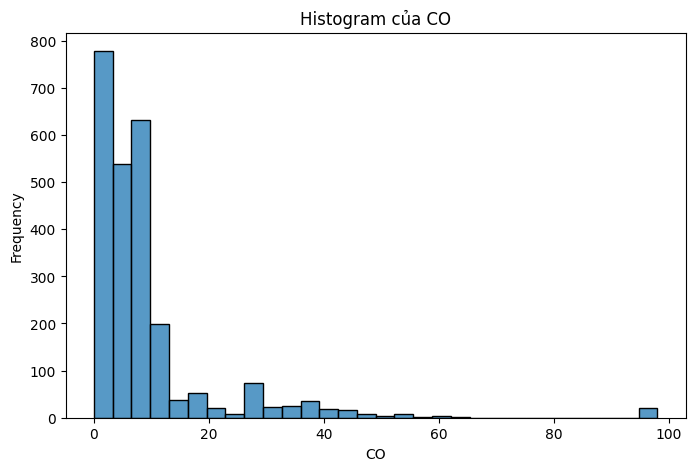

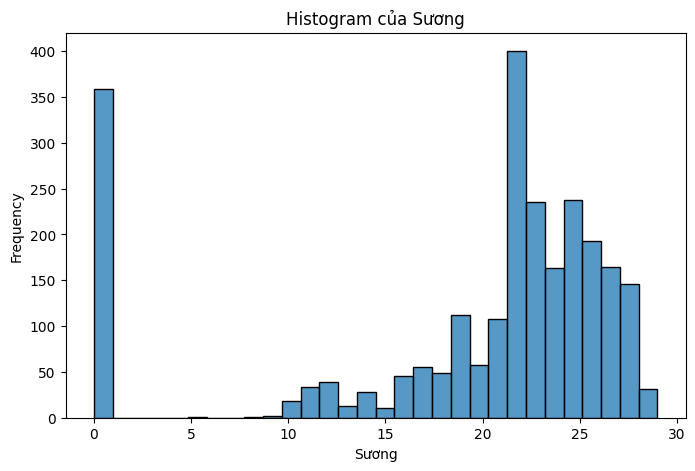

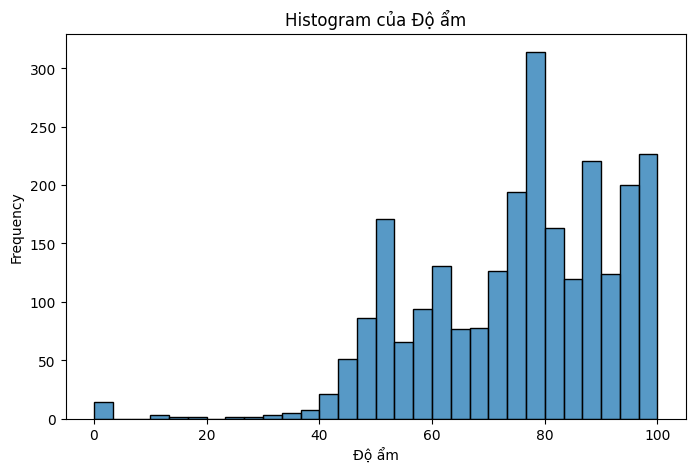

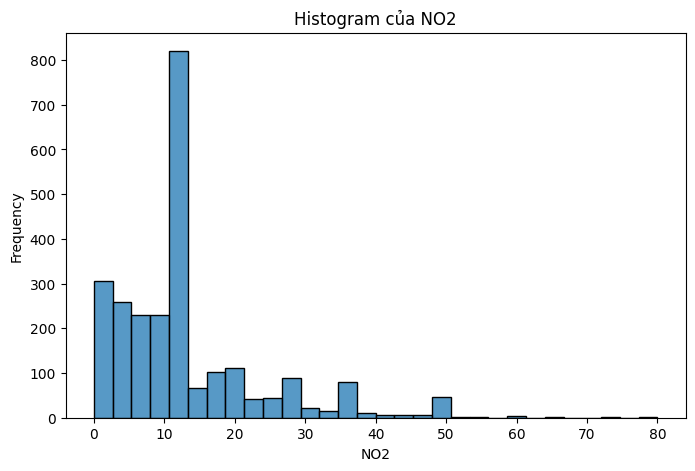

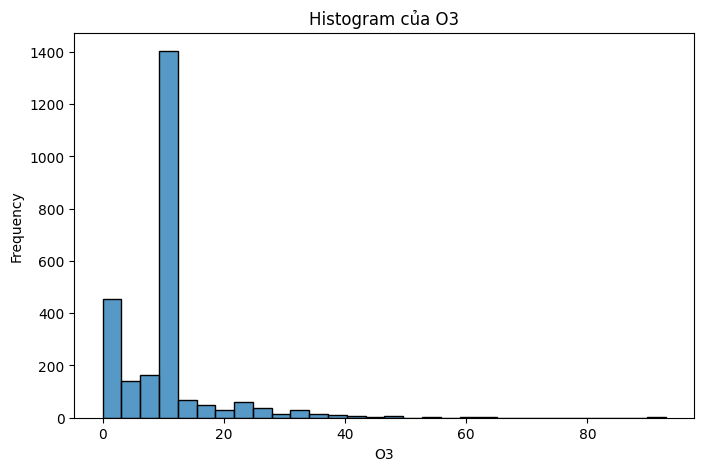

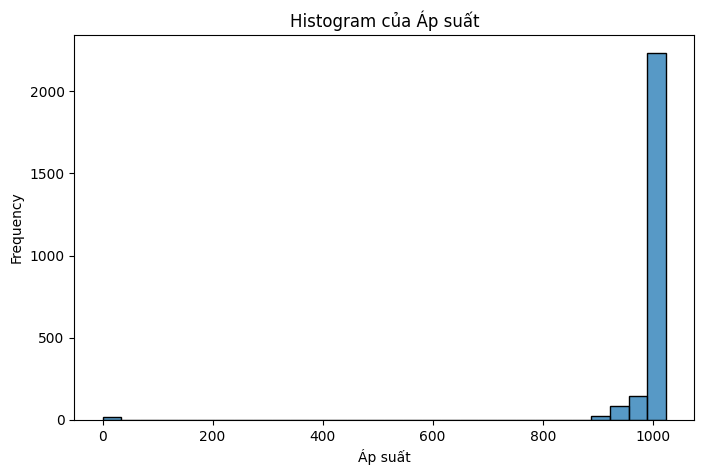

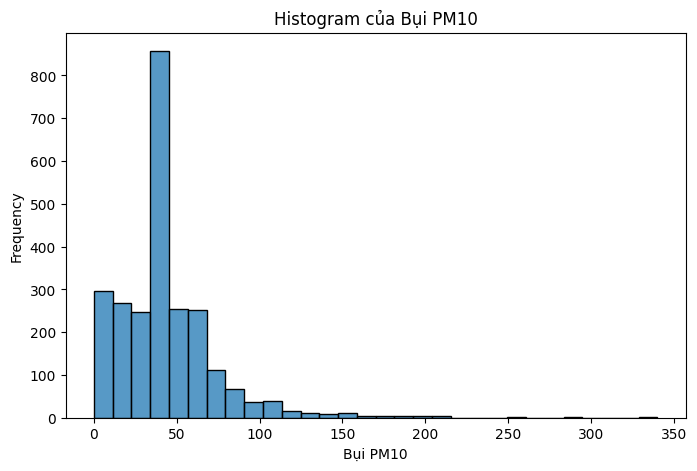

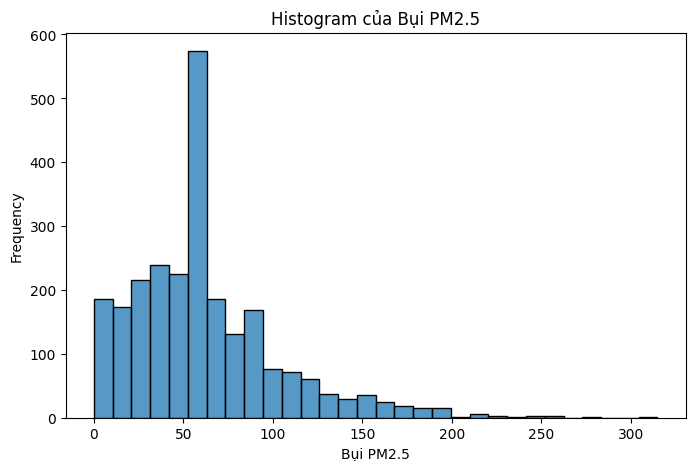

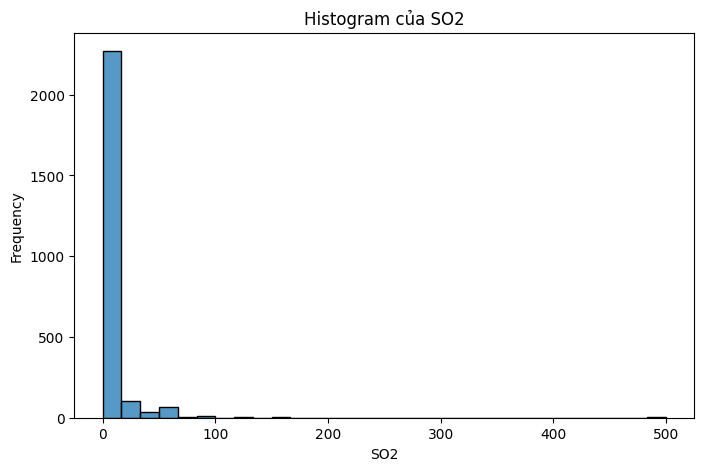

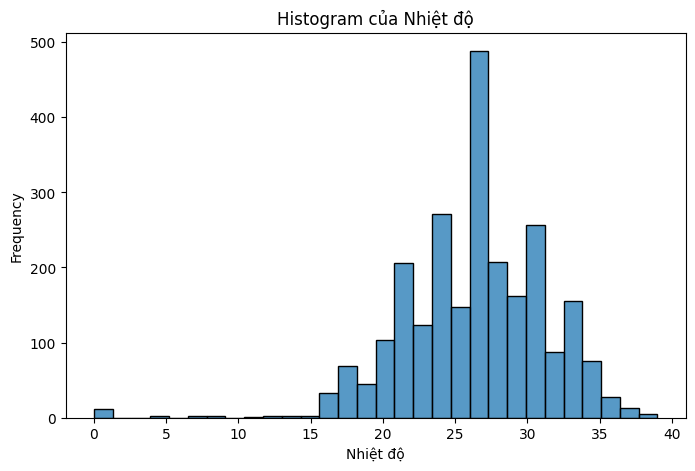

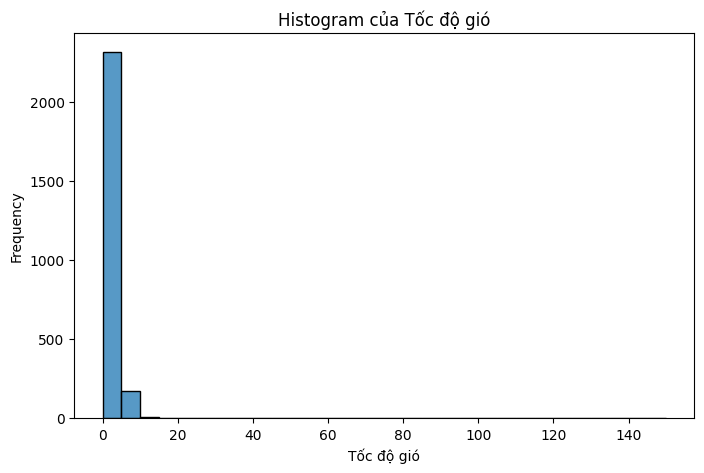

In [ ]:
numeric_features = dataset.select_dtypes(include=['float64']).columns.tolist()

for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(dataset[feature], bins=30, kde=False)
    plt.title(f'Histogram của {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

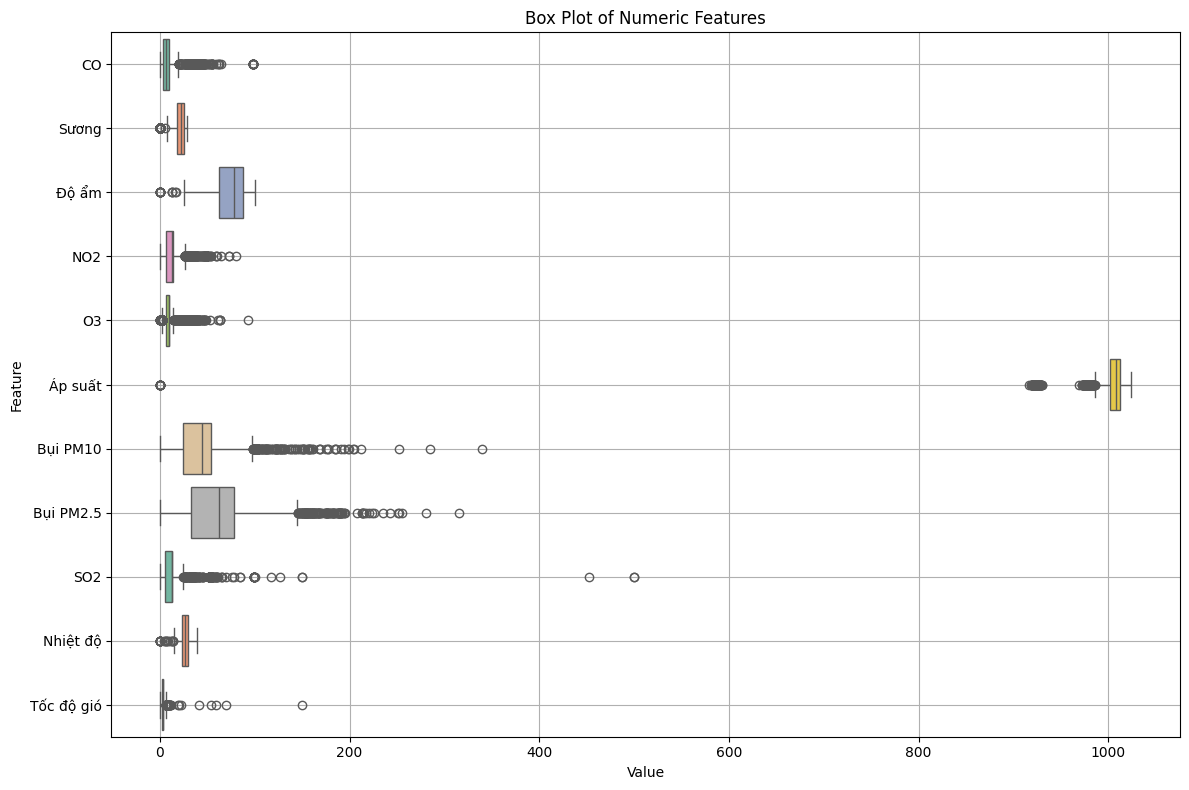

In [ ]:
# Vẽ box plot cho tất cả các đặc trưng định lượng
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset, orient='h', palette='Set2')
plt.title('Box Plot of Numeric Features')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

Ta thấy các đặc trưng có đơn vị giá trị cách xa nhau. Thế nên sử dụng Standard Scaler để chuẩn hóa dữ liệu

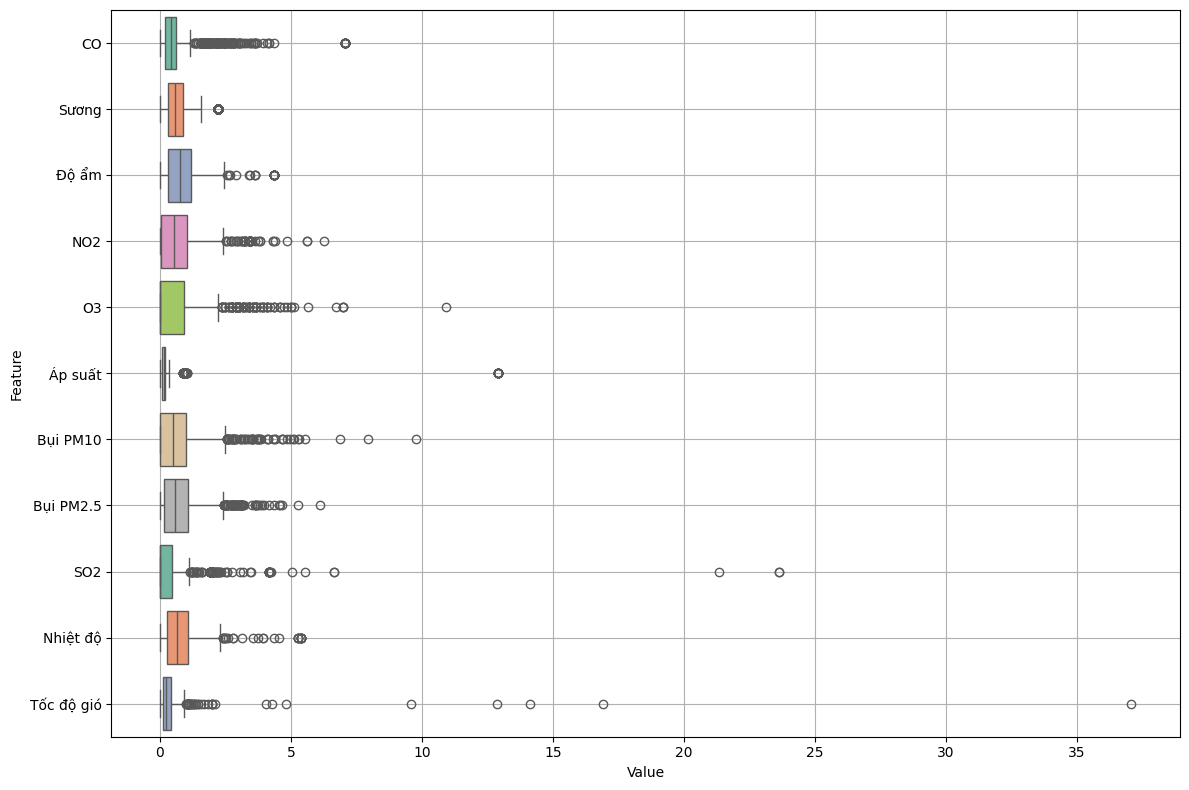

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset[numeric_features] = abs(scaler.fit_transform(dataset[numeric_features]))
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset, orient='h', palette='Set2')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()


Histogram và box plot cho thấy bộ dữ liệu có khá nhiều điểm ngoại lai (outlier). Cần xử lý các điểm ngoại lai này bằng Winsorization là một kỹ thuật xử lý giá trị ngoại lai trong thống kê và khoa học dữ liệu. Kỹ thuật này nhằm thay thế các giá trị ngoại lai bằng các giá trị gần với giới hạn của phân phối, thay vì loại bỏ hoặc thay đổi chúng một cách hoàn toàn.

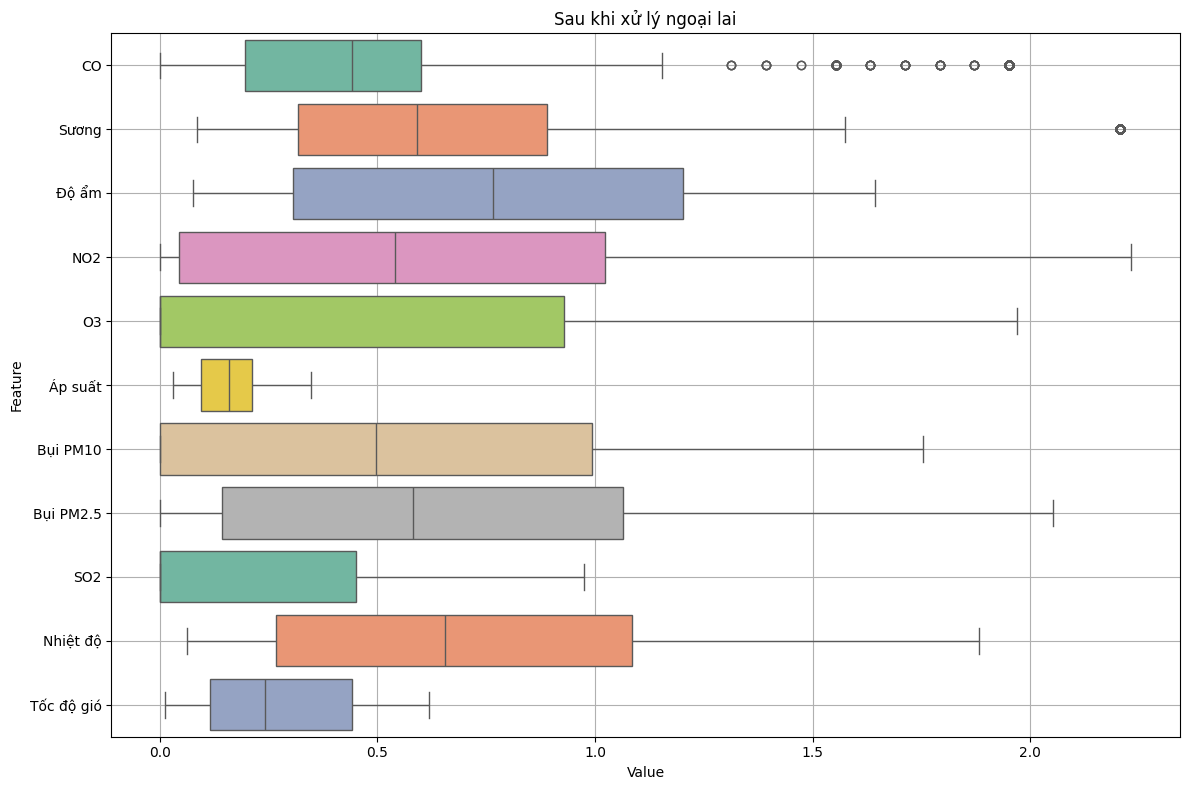

,CO,Sương,Độ ẩm,NO2,O3,Áp suất,Bụi PM10,Bụi PM2.5,SO2,Nhiệt độ,Tốc độ gió,Đánh giá
0,0.000000,2.205199,0.447026,0.000000,0.000000,0.146689,1.451078,0.964417,8.614354e-17,0.142642,0.162961,Không tốt cho nhóm nhạy cảm
1,0.000000,2.205199,0.098585,0.000000,0.000000,0.224367,1.451078,0.000000,8.614354e-17,1.698686,0.366756,Rất không tốt
2,0.736505,2.205199,0.098585,0.429288,1.204328,0.224367,1.451078,2.051211,5.234136e-01,1.698686,0.366756,Rất không tốt
3,0.521141,2.205199,0.877048,0.683234,0.137418,0.347358,0.493281,0.629549,5.767575e-01,0.409757,0.492879,Tốt
4,0.600905,2.205199,0.737393,0.000000,0.000000,0.224367,0.266350,0.143283,8.614354e-17,1.084910,0.492879,Trung bình


In [ ]:
from scipy.stats.mstats import winsorize

for feature in numeric_features:
    dataset[feature] = winsorize(dataset[feature], limits=[0.05, 0.05])

plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset, orient='h', palette='Set2')
plt.title('Sau khi xử lý ngoại lai')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

dataset.head()

In [ ]:
# encoder nhãn
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dataset['Đánh giá'] = label_encoder.fit_transform(dataset['Đánh giá'])

Trích chọn đặc trưng

In [ ]:
# sử dụng label encoder
from sklearn.feature_selection import SelectKBest, chi2
X = dataset.drop(columns=['Đánh giá'])
y = dataset['Đánh giá']
# Selection feature
selector = SelectKBest(score_func=chi2, k=2)
X_new = selector.fit_transform(X, y)

Xây dựng mô hình

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
# Phân chia dữ liệu tỉ lệ 7/3
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3)

scores = []
# Tạo hàm xây dựng mô hình vào đánh giá
def build_and_evaluate_model(algorithm, params, X_train, y_train, X_test, y_test):
    # Khởi tạo mô hình
    model = algorithm(**params)

    # Sử dụng GridSearchCV để tìm hyperparameter
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Huấn luyện mô hình với tham số tốt nhất
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Dùng mô hình dự đoán trên Test Set
    y_pred = best_model.predict(X_test)

    # Đánh giá mô hình
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Lưu kết quả
    scores.append({
        'clf_name': model.__class__.__name__,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    print("A. Best Parameters Found:")
    print(grid_search.best_params_)
    print("\nB. Final Validation on Test Set:")
    final_scores = pd.DataFrame({'accuracy': [accuracy],
                                 'precision': [precision],
                                 'recall': [recall],
                                 'f1': [f1]})
    print(final_scores.to_string(index=False))

    # Trực quan hóa kết quả đánh giá
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    cv_results = grid_search.cv_results_
    cv_scores = cv_results['mean_test_score']
    sns.boxplot(data=cv_scores, orient="h", palette="Set2", ax=axs[0])
    axs[0].set_title("Cross-validation Scores")

    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap=plt.cm.Blues, ax=axs[1])
    axs[1].set_title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

SVM

BUILD AND EVALUATE SVM MODEL
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


A. Best Parameters Found:
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

B. Final Validation on Test Set:
 accuracy  precision  recall      f1
    0.768   0.797603   0.768 0.76701


<ipython-input-18-498df409d571>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_scores, orient="h", palette="Set2", ax=axs[0])


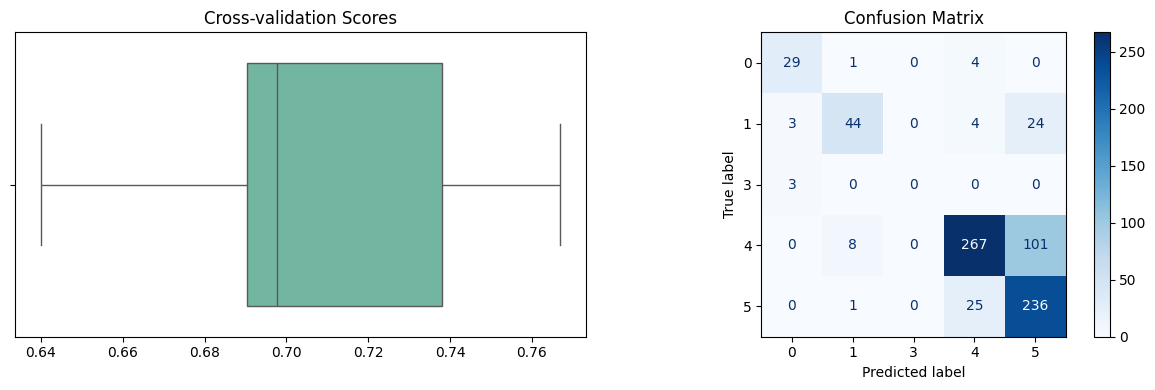

In [ ]:
from sklearn.svm import SVC

print('BUILD AND EVALUATE SVM MODEL')
params = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': [0.1, 1, 'auto']
    }

build_and_evaluate_model(SVC, params, X_train, y_train, X_test, y_test)

Random forest

BUILD AND EVALUATE RANDOMFOREST MODEL
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


A. Best Parameters Found:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

B. Final Validation on Test Set:
 accuracy  precision   recall       f1
 0.874667   0.875688 0.874667 0.871423


<ipython-input-18-498df409d571>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_scores, orient="h", palette="Set2", ax=axs[0])


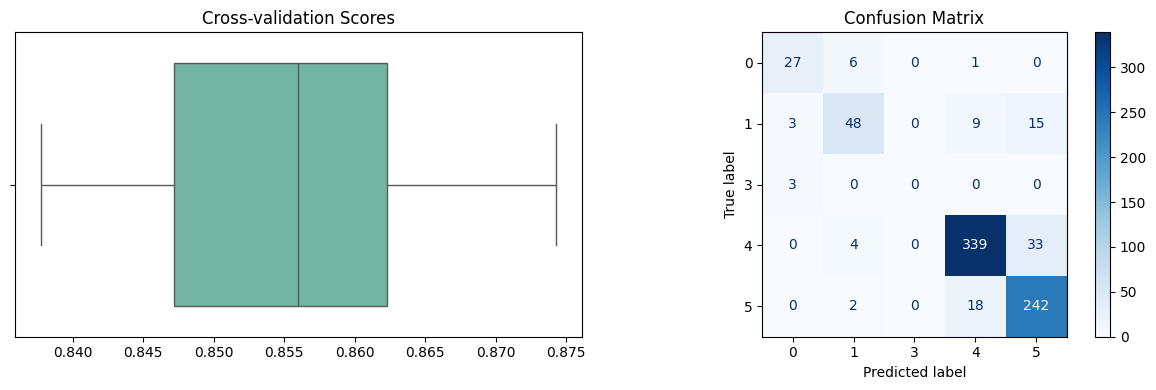

In [ ]:
from sklearn.ensemble import RandomForestClassifier

print('BUILD AND EVALUATE RANDOMFOREST MODEL')
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

build_and_evaluate_model(RandomForestClassifier, params, X_train, y_train, X_test, y_test)

MultiLayerPerceptron

BUILD AND EVALUATE RANDOMFOREST MODEL
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
<ipython-input-18-498df409d571>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_scores, orient="h", palette="Set2", ax=axs[0])


A. Best Parameters Found:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}

B. Final Validation on Test Set:
 accuracy  precision   recall       f1
 0.753333   0.769032 0.753333 0.752603


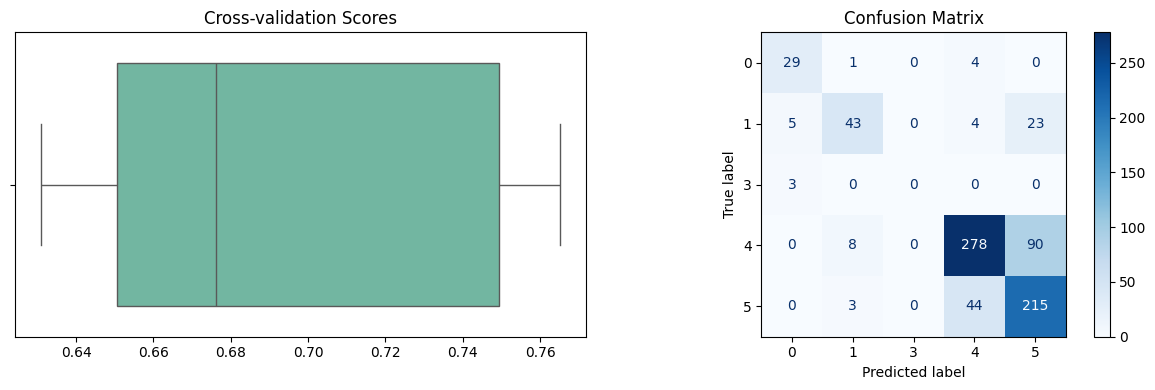

In [ ]:
from sklearn.neural_network import MLPClassifier

print('BUILD AND EVALUATE RANDOMFOREST MODEL')
params = {
    'hidden_layer_sizes': [(50, 50), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
}

build_and_evaluate_model(MLPClassifier, params, X_train, y_train, X_test, y_test)

k-NN

BUILD AND EVALUATE KNN MODEL
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


A. Best Parameters Found:
{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

B. Final Validation on Test Set:
 accuracy  precision   recall       f1
 0.829333   0.831078 0.829333 0.826574


<ipython-input-18-498df409d571>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_scores, orient="h", palette="Set2", ax=axs[0])


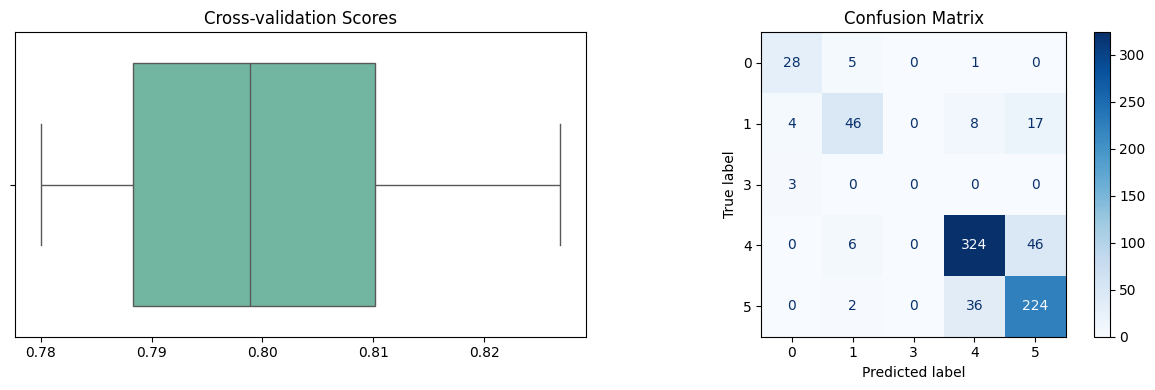

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

print('BUILD AND EVALUATE KNN MODEL')
params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

build_and_evaluate_model(KNeighborsClassifier, params, X_train, y_train, X_test, y_test)

Gaussian Naive Bayes

BUILD AND EVALUATE NAIVEBAYES MODEL
Fitting 5 folds for each of 1 candidates, totalling 5 fits
A. Best Parameters Found:
{}

B. Final Validation on Test Set:
 accuracy  precision   recall       f1
 0.610667    0.61566 0.610667 0.609162


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-18-498df409d571>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_scores, orient="h", palette="Set2", ax=axs[0])


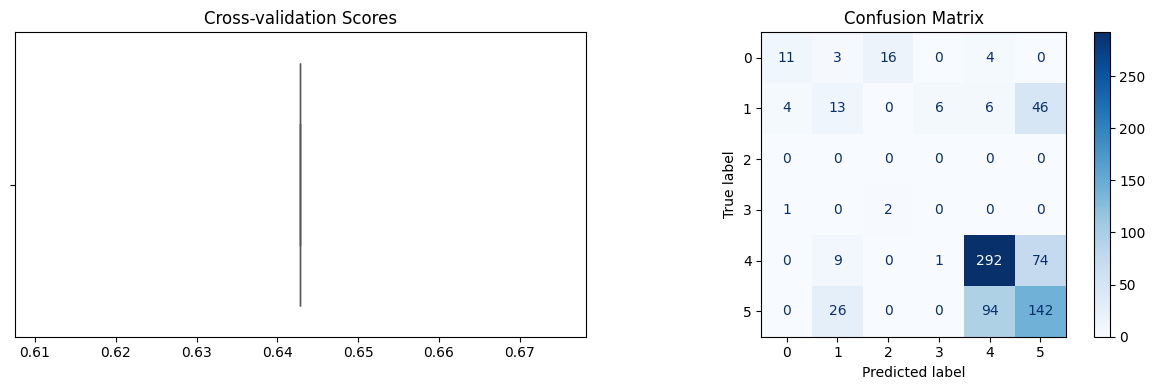

In [ ]:
from sklearn.naive_bayes import GaussianNB

print('BUILD AND EVALUATE NAIVEBAYES MODEL')
params = {}

build_and_evaluate_model(GaussianNB, params, X_train, y_train, X_test, y_test)

+------------------------+----------+-----------+--------+----------+
|       Classifier       | Accuracy | Precision | Recall | F1-Score |
+------------------------+----------+-----------+--------+----------+
|          SVC           |  0.768   |   0.7976  | 0.768  |  0.767   |
| RandomForestClassifier |  0.8747  |   0.8757  | 0.8747 |  0.8714  |
|     MLPClassifier      |  0.7533  |   0.769   | 0.7533 |  0.7526  |
|  KNeighborsClassifier  |  0.8293  |   0.8311  | 0.8293 |  0.8266  |
|       GaussianNB       |  0.6107  |   0.6157  | 0.6107 |  0.6092  |
+------------------------+----------+-----------+--------+----------+


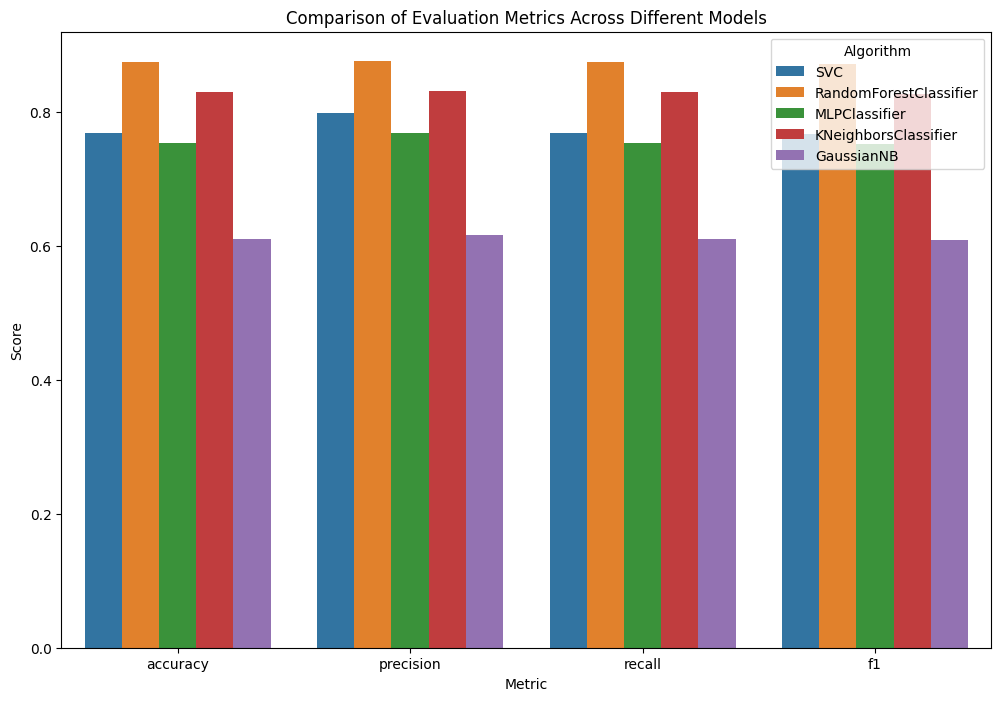

In [ ]:
table = PrettyTable()
table.field_names = ["Classifier", "Accuracy", "Precision", "Recall", "F1-Score"]
for score in scores:
    table.add_row([score['clf_name'],
                   round(score['accuracy'], 4),
                   round(score['precision'], 4),
                   round(score['recall'], 4),
                   round(score['f1'], 4)])
print(table)

def plot_algorithm_comparison(scores):
  df_scores = pd.DataFrame(scores)
  df_long = pd.melt(df_scores, id_vars=['clf_name'], var_name='Metric', value_name='Score')
  plt.figure(figsize=(12, 8))
  sns.barplot(x='Metric', y='Score', hue='clf_name', data=df_long)
  plt.title('Comparison of Evaluation Metrics Across Different Models')
  plt.ylabel('Score')
  plt.xlabel('Metric')
  plt.legend(title='Algorithm')
  plt.show()

plot_algorithm_comparison(scores)

Đánh giá và kết luận:
- Random Forest Classifier là lựa chọn tốt nhất để phân loại chất lượng không khí trong dữ liệu này do hiệu suất vượt trội trên tất cả các chỉ số. Random Forest ít nhạy cảm với điểm ngoại lai nhất so với các thuật toán khác nên đây là thuật toán tốt nhất cho bài toán này.
- KNN Classifier là lựa chọn tốt thứ hai và có thể được sử dụng nếu thời gian huấn luyện và suy luận là một yếu tố quan trọng.
- SVC và MLP Classifier đều có hiệu suất tốt, nhưng không bằng Random Forest và KNN. Tuy nhiên, SVC và MLP có thể phù hợp hơn cho các trường hợp dữ liệu lớn hoặc phức tạp do khả năng của chúng trong việc xử lý dữ liệu phi tuyến tính.
- Gaussian Naive Bayes có hiệu suất kém nhất và có thể không phải là lựa chọn tốt cho bộ dữ liệu này. Tuy nhiên, nó vẫn có thể hữu ích trong các trường hợp dữ liệu có tính chất đặc biệt mà các mô hình khác không nắm bắt được.